# Predicting Bitcoin Price Using RNN

## [Data Source](https://www.investing.com/crypto/bitcoin/btc-usd-historical-data?)

In [1]:
# data file
data = "data/BTC_USD_Historical_Data.csv"

## Look at the data

In [2]:
import pandas as pd
df = pd.read_csv(data)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jun 30, 2020","9,133.0","9,188.9","9,202.0","9,060.0",2.78K,-0.61%
1,"Jun 29, 2020","9,188.9","9,114.9","9,240.4","9,014.9",4.94K,0.83%
2,"Jun 28, 2020","9,113.4","9,009.3","9,191.7","8,933.1",3.23K,1.16%
3,"Jun 27, 2020","9,009.3","9,158.3","9,189.0","8,831.1",4.40K,-1.63%
4,"Jun 26, 2020","9,158.3","9,239.5","9,289.7","9,030.8",7.91K,-0.88%


## Preprocess the data

In [3]:
# We only care about the Price, so drop others
df = pd.DataFrame(df['Price'])

In [4]:
# Reverse the data
df = df[::-1]

In [5]:
# Convert comma separated number string to numbers
import locale
from locale import atof

locale.setlocale(locale.LC_NUMERIC, '')

df = df.applymap(atof)

In [6]:
# Scale the data by 10000
factor = 10000
df['Price'] = df['Price']/factor

In [7]:
# re-index the data
df = df.reset_index(drop=True)

In [8]:
# Show the data
df.head()

,Price
0,0.03767
1,0.03733
2,0.03784
3,0.03793
4,0.03767


## Train-Valid-Test Split

In [9]:
train_rate = 0.7
val_rate = 0.15
test_rate = 0.15

sample_num = len(df)

train_size= int(sample_num * train_rate)
val_size = int(sample_num * val_rate)
test_size = int(sample_num * test_rate)

In [10]:
df_test = df[:test_size]
df_val = df[test_size: test_size + val_size]
df_train = df[test_size+val_size: ]

## Create PyTorch Dataset and DataLoader

In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [12]:
# create time series dataset, using [i:i+window) to predict i+window
def create_time_series(df, window):
    data_list = []

    for i in range(len(df)-window):
        tmp = df["Price"][i:i+window].tolist()
        data_list.append([[item] for item in tmp])

    target_list = df["Price"][window: len(df)].tolist()
    target_list = [[item] for item in target_list]
    return data_list, target_list

In [13]:
class BitcoinDataset(Dataset):
    
    # constructor
    def __init__(self, df, method, window=10):
        # make sure df contains only one column
        assert(df.shape[1] == 1)
        
        self.data_list, self.target_list = method(df, window)
        assert(len(self.data_list) == len(self.target_list))
      
    # return the length of dataset
    def __len__(self):
        return len(self.data_list)
    
    # return the key-th element of dataset
    def __getitem__(self, key, max_sent_length=None):
        if max_sent_length == None:
            max_sent_length = 1
        return torch.tensor(self.data_list[key]), torch.tensor(self.target_list[key])
    
    def get_data_list(self):
        return self.data_list
    
    def get_target_list(self):
        return self.target_list
               

In [89]:
window = 30
train_dataset = BitcoinDataset(df_train, window=window, method=create_time_series)
val_dataset = BitcoinDataset(df_val, window=window, method=create_time_series)
test_dataset = BitcoinDataset(df_test,window=window, method=create_time_series)

In [90]:
batch_size = 64

In [91]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

## Build LSTM to predict bitcoin price based on previous prices

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [93]:
class BitcoinPredictor(nn.Module):
    
    # constructor
    def __init__(self, hidden_size, num_lstm_layers, bidirectional):
        super().__init__()
        
        # input previous prices. there are "window"s of previous prices
        self.lstm = nn.LSTM(input_size=1, 
                            hidden_size=hidden_size,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            bidirectional=bidirectional)
        self.predict = nn.Linear(hidden_size, 1)
        
        pass
    
    def forward(self, inputs):
        out = None
        out, _ = self.lstm(inputs)
        out, _ = torch.max(out, dim=1)
        out = self.predict(out)
        
        return out


## Initial the Bitcoin Price Predicor

In [94]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
import tqdm

In [95]:
hidden_size = 50
num_lstm_layers = 1
bidirectional = False
torch.manual_seed(630)

learning_rate = 0.001

In [96]:
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
else:
    device = torch.device("cpu")   

In [97]:
window=30
model = BitcoinPredictor(hidden_size, num_lstm_layers, bidirectional)

In [98]:
model.to(device)

BitcoinPredictor(
  (lstm): LSTM(1, 50, batch_first=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)

In [99]:
criterion = nn.MSELoss()

In [100]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Start Training

In [101]:
class Learner():
    # constructor
    def __init__(self,  model, criterion, optimizer):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
       
        
    def train(self, train_loader, val_loader, device, num_epochs):
        
        train_loss_history = []
        val_loss_history = []
        
        min_loss = np.Infinity
        for epoch in tqdm.tqdm_notebook(range(num_epochs)):
            self.model.train()

            for i, (data_batch, target_batch) in enumerate(train_loader):
                preds = self.model(data_batch.to(device))
                train_loss = self.criterion(preds, target_batch.to(device))
                train_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_loss_history.append(train_loss.item())
            
            batch_min_loss = np.Infinity
            for i, (data_batch, target_batch) in enumerate(val_loader):
                preds = self.model(data_batch.to(device))
                val_loss = criterion(preds, target_batch.to(device))
                optimizer.zero_grad()
                val_loss_history.append(val_loss.item())
                
                if val_loss < batch_min_loss:
                    batch_min_loss = val_loss
            
            if batch_min_loss < min_loss:
                min_loss = batch_min_loss
                torch.save(model, 'best_model.pt')
                
            print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {val_loss}")
        
        return train_loss_history, val_loss_history
    
    def do_test(self, test_loader, device, best_model=None):
        if best_model == None:
            best_model = self.model
            
        real_data = []
        pred_data = []
        for i, (data_batch, target_batch) in enumerate(test_loader):
            preds = best_model(data_batch.to(device))
            test_loss = self.criterion(preds, target_batch.to(device))
            optimizer.zero_grad()

            for i in range(len(target_batch)):
                real_data.append(target_batch.__getitem__(i).item())
                pred_data.append(preds.__getitem__(i).item())
        
        return real_data, pred_data
            

In [102]:
NUM_EPOCHS = 100
learner = Learner(model, criterion, optimizer)

In [103]:
train_loss_history, val_loss_history = learner.train(train_loader, val_loader, device, NUM_EPOCHS)

/Users/zhousicheng/Projects/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/Users/zhousicheng/Projects/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BitcoinPredictor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 0, train_loss: 0.5244047045707703, valid_loss: 0.0076646702364087105
Epoch: 1, train_loss: 0.003543405095115304, valid_loss: 0.26496070623397827
Epoch: 2, train_loss: 0.027186905965209007, valid_loss: 0.14454925060272217
Epoch: 3, train_loss: 0.004470092710107565, valid_loss: 0.09087128937244415
Epoch: 4, train_loss: 0.002150010084733367, valid_loss: 0.03824431076645851
Epoch: 5, train_loss: 0.021924586966633797, valid_loss: 0.018452946096658707
Epoch: 6, train_loss: 0.014917447231709957, valid_loss: 0.01647493802011013
Epoch: 7, train_loss: 0.012314396910369396, valid_loss: 0.014151264913380146
Epoch: 8, train_loss: 0.00885448232293129, valid_loss: 0.013202073983848095
Epoch: 9, train_loss: 0.003835231764242053, valid_loss: 0.014426982030272484
Epoch: 10, train_loss: 0.0016181402606889606, valid_loss: 0.01601889543235302
Epoch: 11, train_loss: 0.001525789382867515, valid_loss: 0.014156241901218891
Epoch: 12, train_loss: 0.0015700111398473382, valid_loss: 0.010422172024846077
Ep

## Test the model

In [104]:
best_model = torch.load("best_model.pt")

In [105]:
real_data, pred_data = learner.do_test(test_loader, device, best_model=best_model)

In [106]:
import matplotlib.pyplot as plt

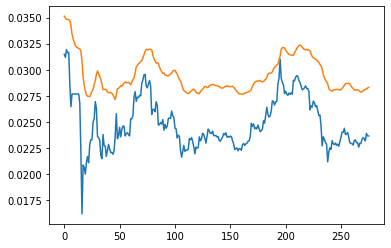

In [107]:
plt.plot(real_data)
plt.plot(pred_data)
plt.show()

## Let the model do predict using the predict result itself generated

In [167]:
df_init_real_data = pd.read_csv(data)
df_init = pd.DataFrame(df_init_real_data['Price'])[:window]
df_init = df_init.applymap(atof)
df_init['Price'] /= factor

In [144]:
def create_time_series_pred(df, window):
    assert(len(df) == window)
    data_list = []
    target_list = []
    
    tmp = df["Price"].to_list()
    data_list.append([[item] for item in tmp])
    target_list.append(-1)
    
    return data_list, target_list

In [171]:
def predict_next_n_days(df_init,window, n, model):
    pred_data = []
    for i in range(n):
        df_tmp = df_init[i:i+window]
        tmp_dataset = BitcoinDataset(df_tmp, window=window, method=create_time_series_pred)
        tmp_loader = DataLoader(tmp_dataset, batch_size=1, shuffle=False)
        
        for batch_index, (data_batch, target_batch) in enumerate(tmp_loader):
            preds = model(data_batch)
            for item_index in range(len(data_batch)):
                tmp_pred = preds.__getitem__(item_index).item()
                pred_data.append(tmp_pred)
                df_init = df_init.append({'Price': tmp_pred}, ignore_index=True)
    return pred_data

In [206]:
pred_data = predict_next_n_days(df_init, window=30, n=4, model=best_model)

In [208]:
[factor* item for item in pred_data]

[9964.298009872437, 7142.28630065918, 6992.6488399505615, 6906.629800796509]

## Research the model step by step

In [27]:
# prepare a batch of data
data_batch, target_batch = next(iter(test_loader))

In [38]:
# model: lstm layer
lstm = nn.LSTM(input_size=1, 
                hidden_size=25,
                num_layers=1,
                batch_first=True,
                bidirectional=False)

In [57]:
# criterion
criterion = nn.MSELoss()

In [39]:
# fully connected layer
linear = nn.Linear(25, 1)

In [43]:
# output of the model
lstm_out, _ = lstm(data_batch)

In [44]:
lstm_out.shape

torch.Size([64, 10, 25])

In [48]:
max_lstm_out, _ = torch.max(lstm_out, dim=1)

In [49]:
max_lstm_out.shape

torch.Size([64, 25])

In [50]:
pred = linear(max_lstm_out)

In [53]:
pred.shape

torch.Size([64, 1])

In [54]:
target_batch.shape

torch.Size([64, 1])

In [58]:
loss = criterion(pred, target_batch)

In [61]:
loss.backward()

In [62]:
optimizer.step()

In [63]:
optimizer.zero_grad()

In [64]:
loss

tensor(0.0023, grad_fn=<MseLossBackward>)